In [1]:


# call __init_ to set notebook seed
import set_notebook_env
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu

from collections import defaultdict
import numpy as np

import set_notebook_env
loader, plot_utils = set_notebook_env.set_env(
    data_dir="../data/", 
    min_ratings=0, 
    max_ratings=None,
    drop_inconsistent_gender = True
)

SEED = np.random.get_state()[1][0]


Using seed: 18787288


In [2]:
loader.initial_setup()
loader.add_tag_intensity_score()
prepared_df = loader.add_gender_code(loader.prepared_df)
prepared_df.columns
tag_columns = loader.tag_cols
tag_columns

['tough_grader',
 'good_feedback',
 'respected',
 'lots_to_read',
 'participation_matters',
 'no_skip',
 'lots_of_hw',
 'inspirational',
 'pop_quizzes',
 'accessible',
 'papers',
 'clear_grading',
 'hilarious',
 'test_heavy',
 'few_things',
 'amazing_lectures',
 'caring',
 'extra_credit',
 'group_projects',
 'lecture_heavy']

In [3]:
agg_tag_columns = loader.find_agg_tag_columns("tag_intensity_score")
agg_tag_columns

# for eachh describe
for t in agg_tag_columns:
    print(prepared_df[t].describe())

count    52088.000000
mean         0.171455
std          0.290530
min          0.000000
25%          0.000000
50%          0.000000
75%          0.250000
max          2.000000
Name: tag_intensity_score_tough_grader, dtype: float64
count    52088.000000
mean         0.252084
std          0.320407
min          0.000000
25%          0.000000
50%          0.111111
75%          0.461538
max          2.000000
Name: tag_intensity_score_good_feedback, dtype: float64
count    52088.000000
mean         0.155601
std          0.258141
min          0.000000
25%          0.000000
50%          0.000000
75%          0.250000
max          2.000000
Name: tag_intensity_score_respected, dtype: float64
count    52088.000000
mean         0.135162
std          0.254281
min          0.000000
25%          0.000000
50%          0.000000
75%          0.181818
max          2.000000
Name: tag_intensity_score_lots_to_read, dtype: float64
count    52088.000000
mean         0.172461
std          0.276038
min         

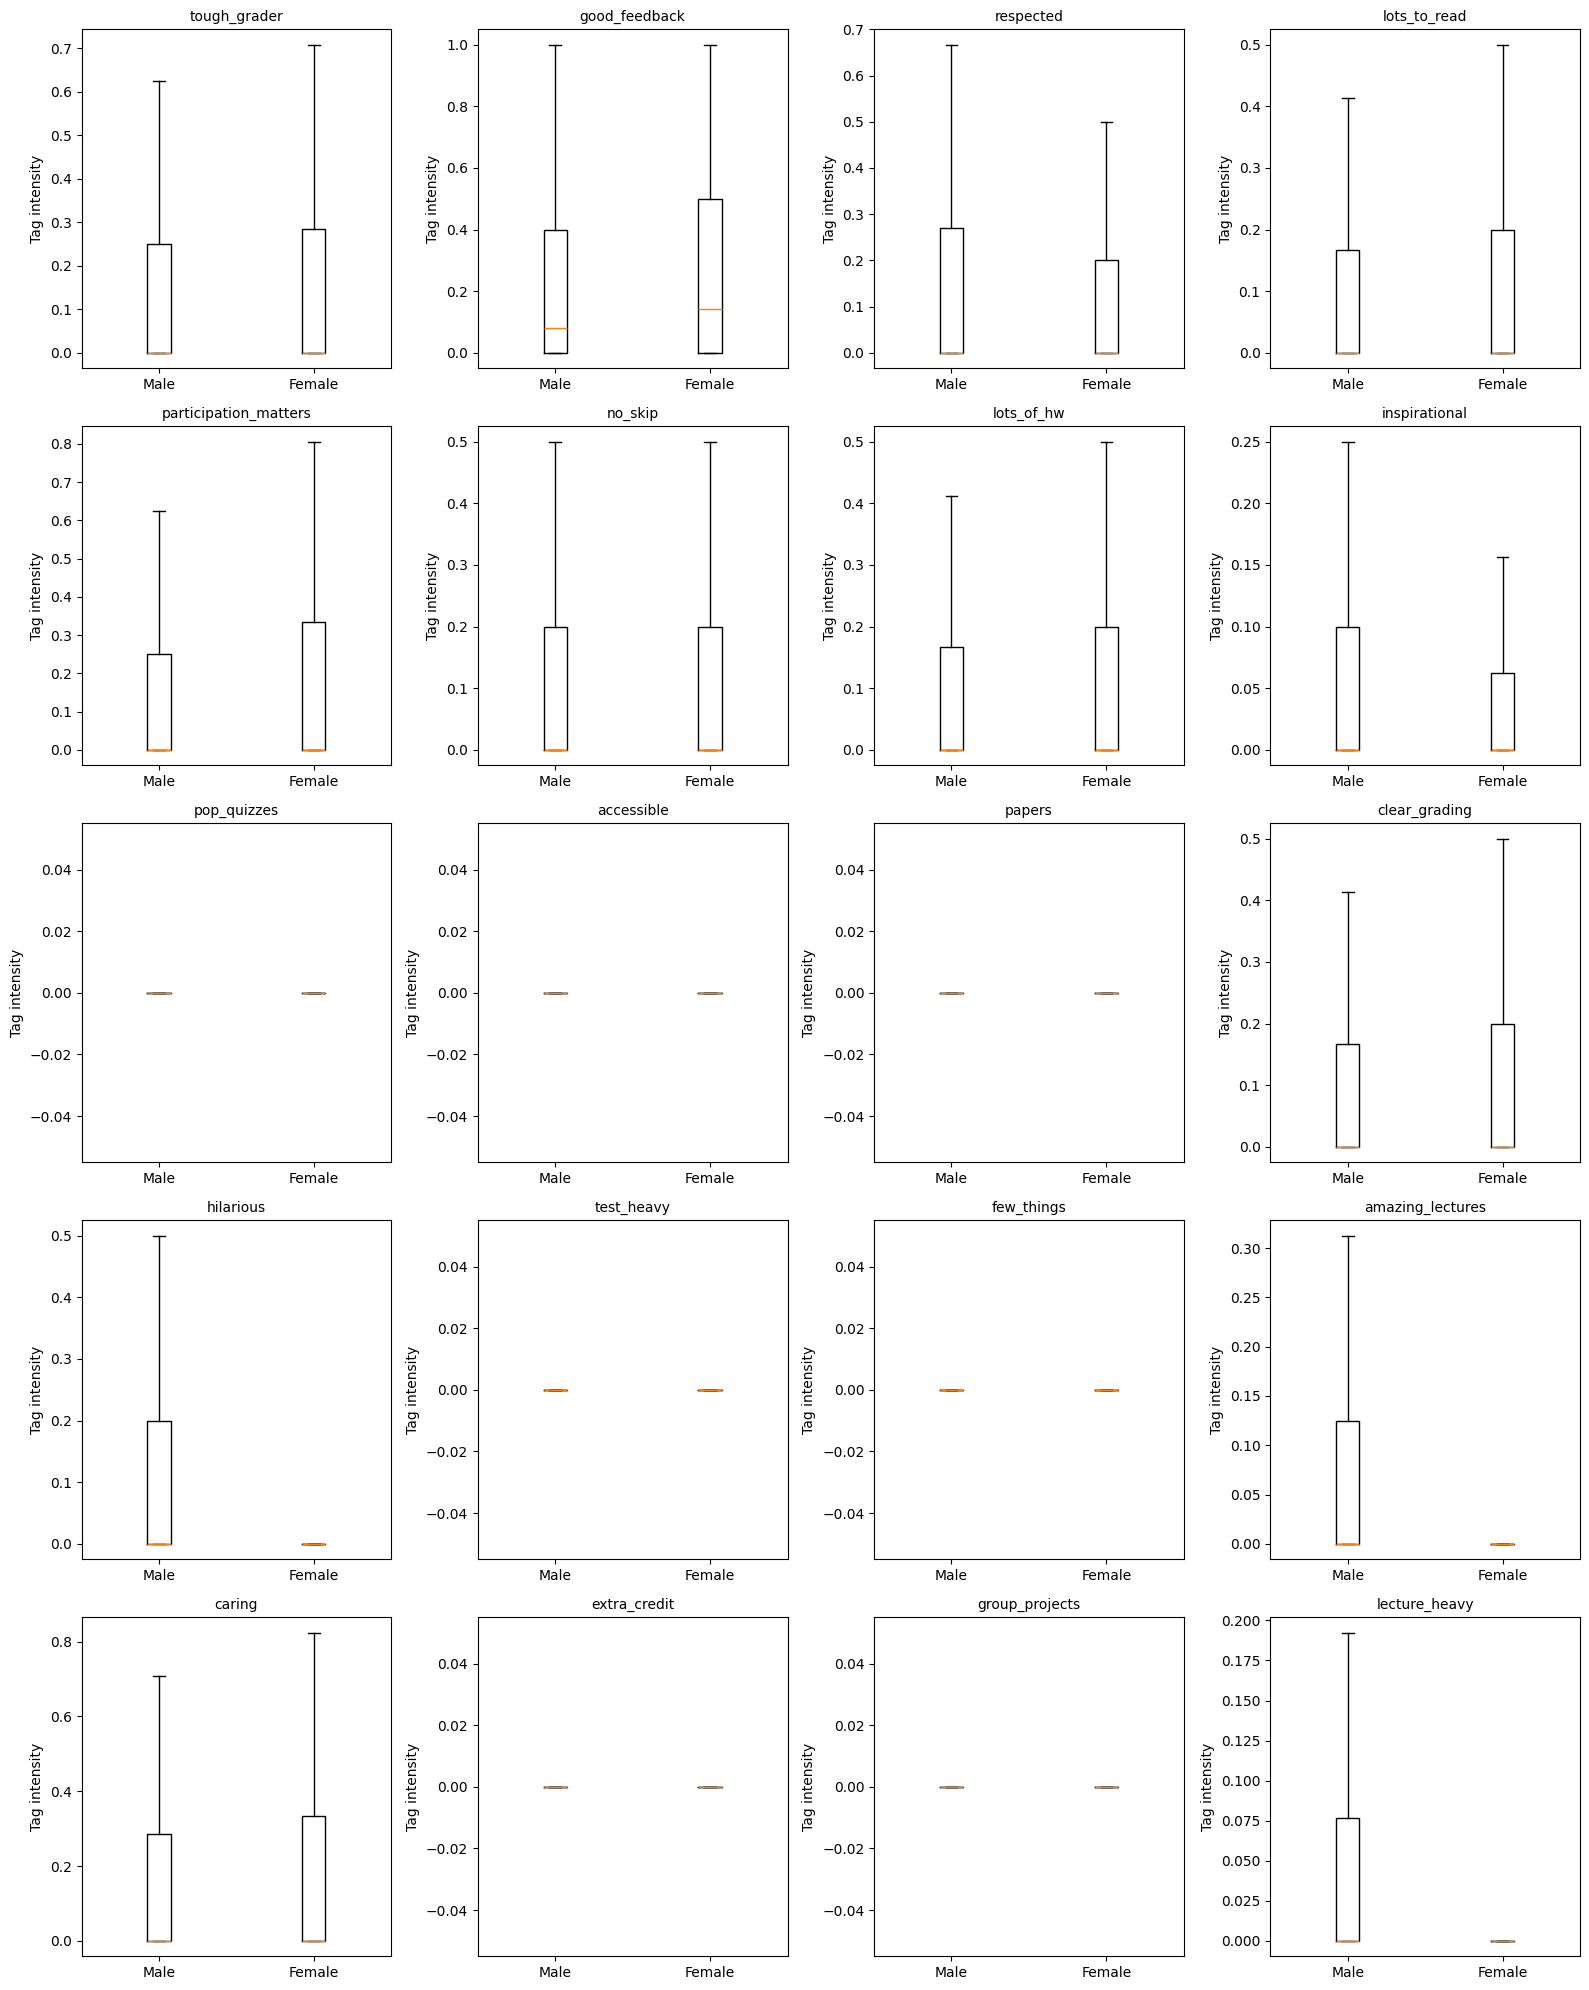

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

cols = agg_tag_columns
n = len(cols)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    df_plot = prepared_df[[col, "gender_code"]].copy()

    # cap extreme values for visualization only
    cap = df_plot[col].quantile(0.99)
    df_plot[col] = np.minimum(df_plot[col], cap)

    male = df_plot.loc[df_plot["gender_code"] == 0, col]
    female = df_plot.loc[df_plot["gender_code"] == 1, col]

    ax.boxplot(
        [male, female],
        labels=["Male", "Female"],
        showfliers=False
    )

    ax.set_title(col.replace("tag_intensity_score_", ""), fontsize=10)
    ax.set_ylabel("Tag intensity")

# hide unused axes
for ax in axes[len(cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


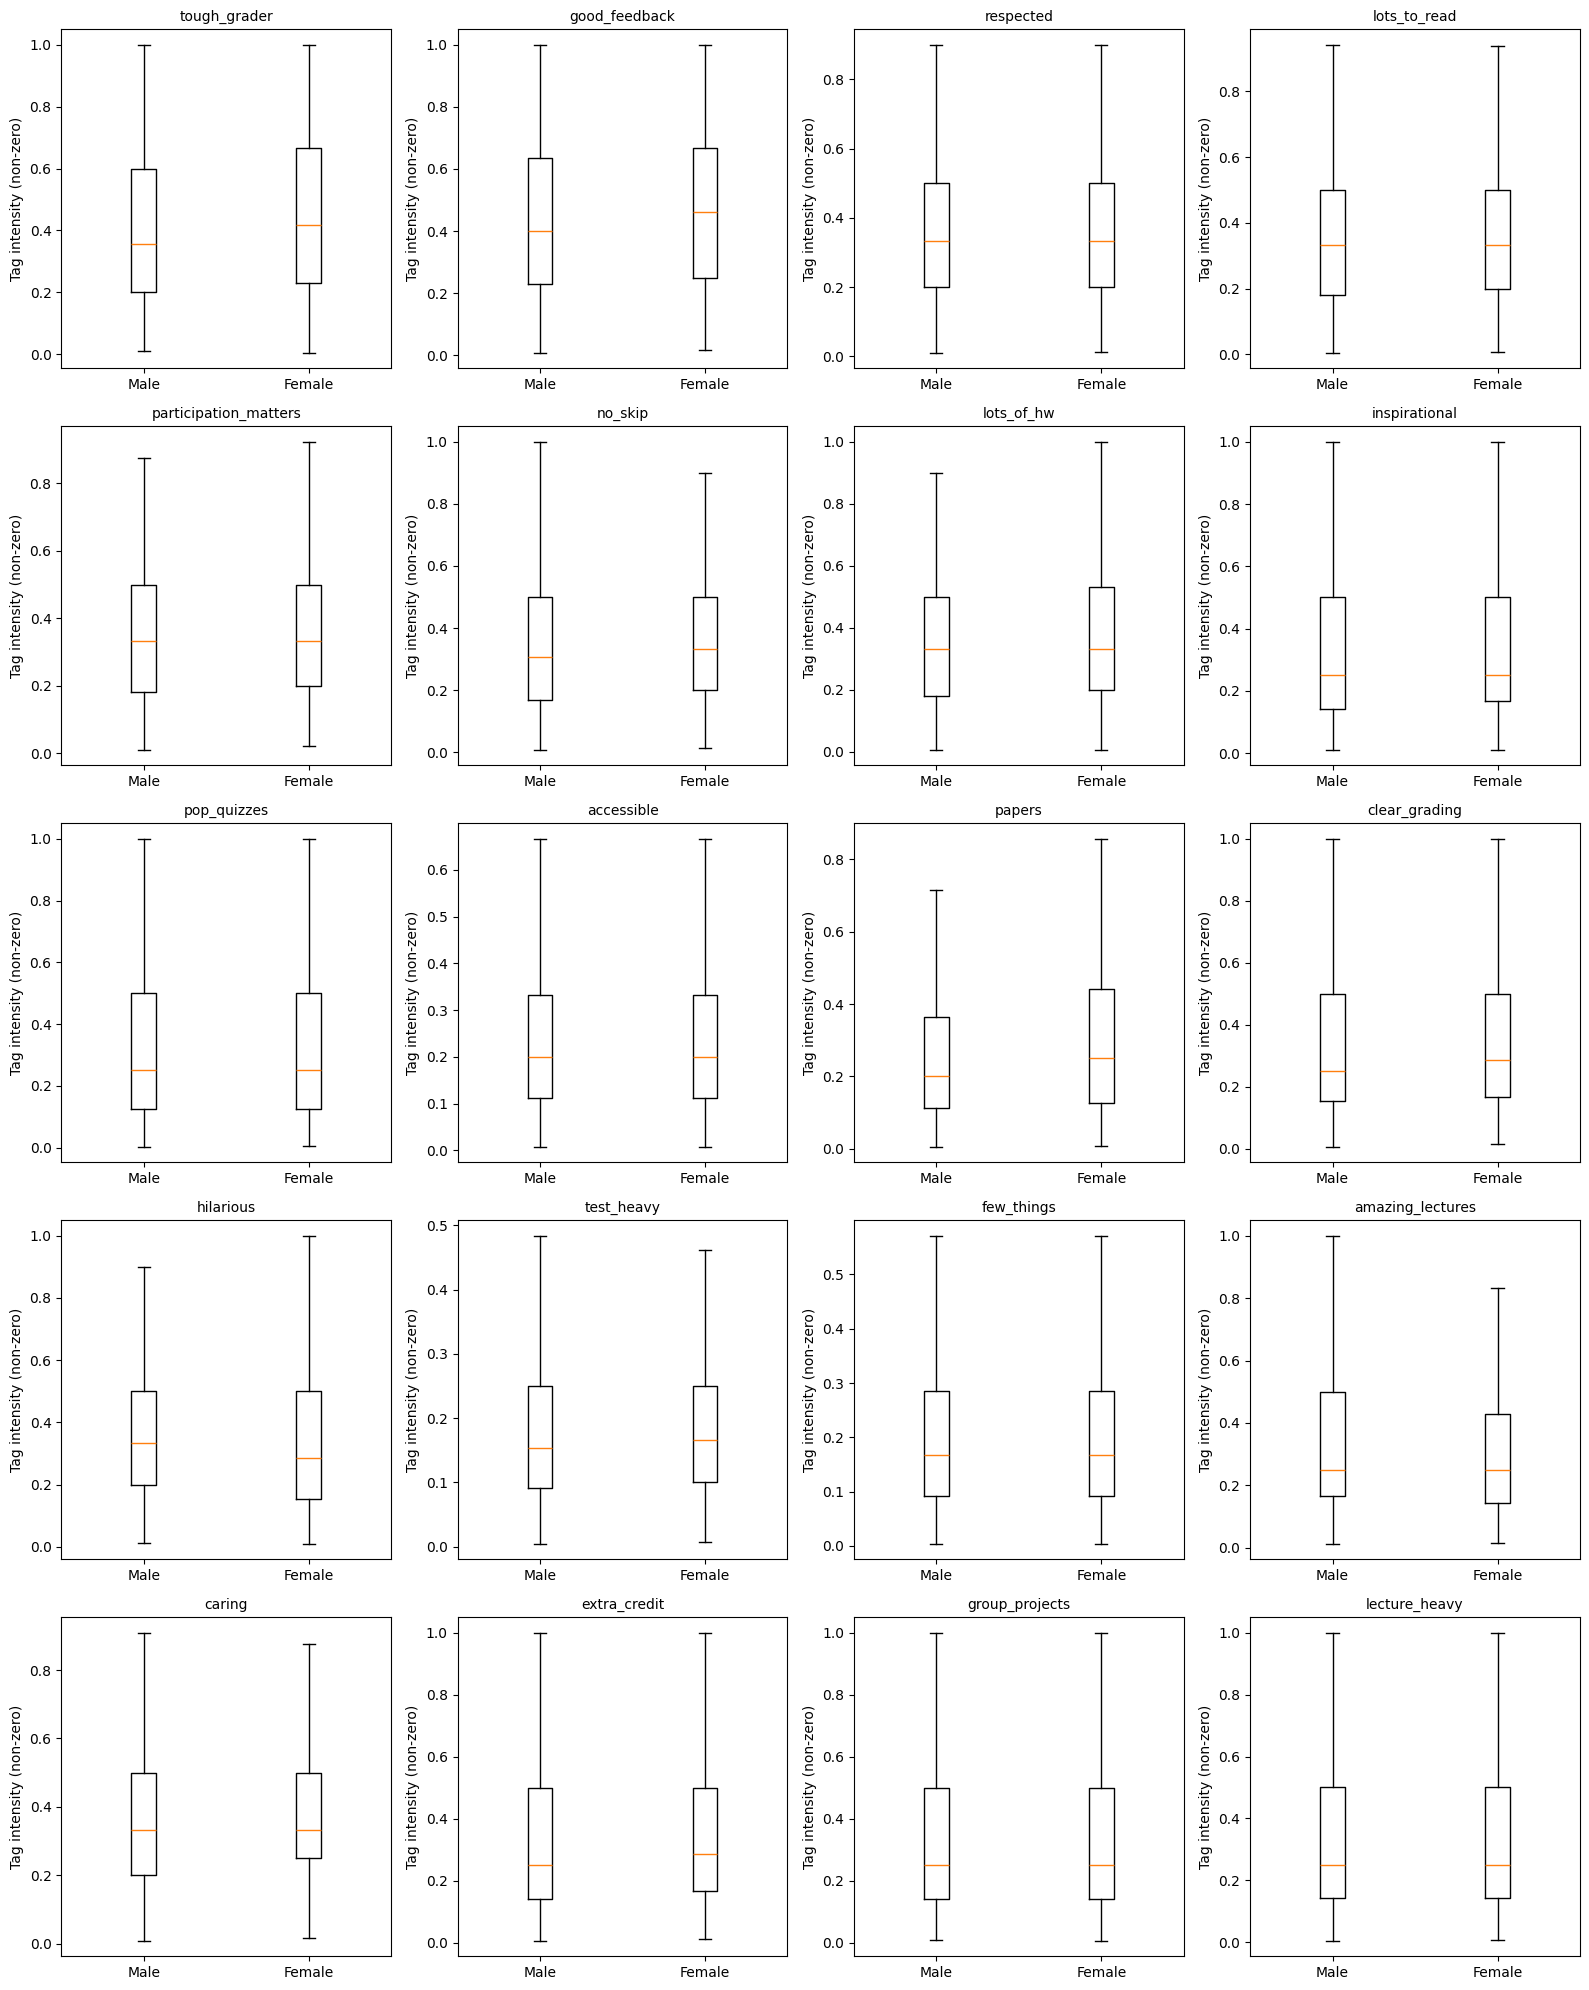

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math

cols = agg_tag_columns
n = len(cols)
ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    df_plot = prepared_df[[col, "gender_code"]].copy()

    # keep only non-zero values
    df_plot = df_plot[df_plot[col] > 0]

    # skip if too few observations
    if df_plot.empty:
        ax.axis("off")
        continue

    # cap extreme values for visualization only
    cap = df_plot[col].quantile(0.99)
    df_plot[col] = np.minimum(df_plot[col], cap)

    male = df_plot.loc[df_plot["gender_code"] == 0, col]
    female = df_plot.loc[df_plot["gender_code"] == 1, col]

    # skip if one gender has no non-zero values
    if len(male) == 0 or len(female) == 0:
        ax.axis("off")
        continue

    ax.boxplot(
        [male, female],
        labels=["Male", "Female"],
        showfliers=False
    )

    ax.set_title(col.replace("tag_intensity_score_", ""), fontsize=10)
    ax.set_ylabel("Tag intensity (non-zero)")

# hide unused axes
for ax in axes[len(cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [6]:
ratings = prepared_df['avg_rating'].to_numpy()
gender = prepared_df['gender_code'].to_numpy()

In [7]:
import numpy as np

def perm_test_zero_prop(x_female, x_male, B=5000, seed=0):
    rng = np.random.default_rng(seed)

    # indicator: 1 if zero, 0 otherwise
    z_f = (x_female == 0).astype(int)
    z_m = (x_male == 0).astype(int)

    obs = z_f.mean() - z_m.mean()

    pooled = np.concatenate([z_f, z_m])
    n_f = len(z_f)

    count = 0
    for _ in range(B):
        rng.shuffle(pooled)
        stat = pooled[:n_f].mean() - pooled[n_f:].mean()
        if abs(stat) >= abs(obs):
            count += 1

    p = (count + 1) / (B + 1)
    return obs, p


In [8]:
results = []

for col in agg_tag_columns:
    female = prepared_df.loc[prepared_df["gender_code"] == 1, col]
    male = prepared_df.loc[prepared_df["gender_code"] == 0, col]

    diff, p = perm_test_zero_prop(female, male)

    results.append({
        "tag": col.replace("tag_intensity_score_", ""),
        "diff_zero_prop_f_minus_m": diff,
        "p_value": p
    })

res_df = pd.DataFrame(results).sort_values("p_value")
res_df


,tag,diff_zero_prop_f_minus_m,p_value
9,accessible,0.020439,0.000200
17,extra_credit,-0.021987,0.000200
16,caring,-0.033900,0.000200
15,amazing_lectures,0.068505,0.000200
14,few_things,0.035494,0.000200
13,test_heavy,0.020474,0.000200
12,hilarious,0.132999,0.000200
10,papers,-0.020314,0.000200
18,group_projects,-0.029299,0.000200
19,lecture_heavy,0.057589,0.000200


In [9]:
most_gendered = (
    res_df
    .sort_values("p_value")
    .head(3)[[
        "tag",
        "diff_zero_prop_f_minus_m",
        "p_value"
    ]]
)

most_gendered


,tag,diff_zero_prop_f_minus_m,p_value
9,accessible,0.020439,0.0002
1,good_feedback,-0.028772,0.0002
2,respected,0.060137,0.0002


In [10]:
least_gendered = (
    res_df
    .sort_values("p_value")
    .tail(3)[[
        "tag",
        "diff_zero_prop_f_minus_m",
        "p_value"
    ]]
)

least_gendered

,tag,diff_zero_prop_f_minus_m,p_value
0,tough_grader,-0.007010,0.099580
5,no_skip,-0.003516,0.413117
11,clear_grading,-0.000372,0.928614


In [11]:
import numpy as np

def perm_test_stat(x_f, x_m, stat_fn=np.median, B=5000, seed=0):
    rng = np.random.default_rng(seed)
    x_f = np.asarray(x_f)
    x_m = np.asarray(x_m)

    obs = stat_fn(x_f) - stat_fn(x_m)

    pooled = np.concatenate([x_f, x_m])
    n_f = len(x_f)

    count = 0
    for _ in range(B):
        rng.shuffle(pooled)
        stat = stat_fn(pooled[:n_f]) - stat_fn(pooled[n_f:])
        if abs(stat) >= abs(obs):
            count += 1

    p = (count + 1) / (B + 1)
    return obs, p

results_nz = []

for col in agg_tag_columns:
    f = prepared_df.loc[prepared_df["gender_code"] == 1, col]
    m = prepared_df.loc[prepared_df["gender_code"] == 0, col]

    f_nz = f[f > 0]
    m_nz = m[m > 0]

    # skip tags with too few non-zero values
    if len(f_nz) < 1 or len(m_nz) < 1:
        continue

    diff, p = perm_test_stat(f_nz, m_nz, stat_fn=np.median, B=5000, seed=42)

    results_nz.append({
        "tag": col.replace("tag_intensity_score_", ""),
        "diff_median_nonzero_f_minus_m": diff,
        "p_value_nonzero": p,
        "n_nonzero_female": len(f_nz),
        "n_nonzero_male": len(m_nz)
    })

res_nz_df = pd.DataFrame(results_nz).sort_values("p_value_nonzero")
res_nz_df


,tag,diff_median_nonzero_f_minus_m,p_value_nonzero,n_nonzero_female,n_nonzero_male
0,tough_grader,0.059524,0.000200,9371,10022
1,good_feedback,0.061538,0.000200,13560,13996
12,hilarious,-0.047619,0.000200,5038,9103
11,clear_grading,0.035714,0.000200,8922,9713
5,no_skip,0.025641,0.000600,8971,9681
13,test_heavy,0.012821,0.105979,1981,2715
10,papers,0.050000,0.110378,2793,2492
17,extra_credit,0.035714,0.163367,5727,5644
16,caring,0.000000,1.000000,11681,11809
15,amazing_lectures,0.000000,1.000000,5749,8126


In [12]:
most_gendered = (
    res_nz_df
    .sort_values("p_value_nonzero")
    .head(3)[[
        "tag",
        "diff_median_nonzero_f_minus_m",
        "p_value_nonzero"
    ]]
)

most_gendered


,tag,diff_median_nonzero_f_minus_m,p_value_nonzero
0,tough_grader,0.059524,0.0002
1,good_feedback,0.061538,0.0002
12,hilarious,-0.047619,0.0002


In [13]:
least_gendered = (
    res_nz_df
    .loc[res_nz_df["p_value_nonzero"] != 1]
    .tail(3)[[
        "tag",
        "diff_median_nonzero_f_minus_m",
        "p_value_nonzero"
    ]]
)

least_gendered


,tag,diff_median_nonzero_f_minus_m,p_value_nonzero
13,test_heavy,0.012821,0.105979
10,papers,0.050000,0.110378
17,extra_credit,0.035714,0.163367


In [14]:
least_gendered = (
    res_nz_df
    .tail(3)[[
        "tag",
        "diff_median_nonzero_f_minus_m",
        "p_value_nonzero"
    ]]
)

least_gendered


,tag,diff_median_nonzero_f_minus_m,p_value_nonzero
2,respected,0.0,1.0
18,group_projects,0.0,1.0
19,lecture_heavy,0.0,1.0
